In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from pathlib import Path
import torchaudio
import fairseq
import torch

In [3]:
def get_mos_data(split):
    mos_list_file = f'../data/phase1-main/DATA/sets/{split}_mos_list.txt'
    mos_data = {}
    for line in open(mos_list_file):
        file_id, mos = line.rstrip().split(',')
        mos = float(mos)
        mos_data[file_id] = mos
    return mos_data

In [4]:
train_mos_data = get_mos_data('train')
len(train_mos_data)

4974

In [5]:
val_mos_data = get_mos_data('val')
len(val_mos_data)

1066

In [6]:
wav_dir = Path('../data/phase1-main/DATA/wav/')

wavpath = wav_dir / 'sys64e2f-utt9c183cd.wav'
wav = torchaudio.load(wavpath)[0]
wav.size()

torch.Size([1, 42944])

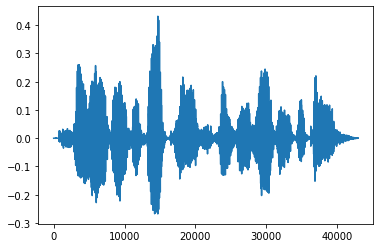

In [7]:
plt.plot(wav.numpy().ravel())

In [8]:
fairseq_base_model = '../fairseq/wav2vec_small.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([fairseq_base_model])
# model

In [9]:
ssl_model = model[0]

In [10]:
ssl_model.remove_pretraining_modules()
ssl_model.eval();

In [11]:
output_wavs = torch.stack([wav], dim=0)
output_wavs.size()

torch.Size([1, 1, 42944])

In [12]:
res = ssl_model(wav, mask=False, features_only=True)
res

{'x': tensor([[[ 0.2308,  0.2443,  0.5489,  ...,  0.1755,  0.2310,  0.0209],
          [ 0.1517,  0.2802,  0.5355,  ...,  0.0818,  0.1908, -0.0885],
          [ 0.1226,  0.1786,  0.3876,  ...,  0.2740,  0.1080, -0.3020],
          ...,
          [ 0.0189,  0.1625,  0.0571,  ...,  0.3395,  0.1968, -0.2756],
          [-0.0990,  0.1637, -0.0284,  ...,  0.2287,  0.5408, -0.3334],
          [ 0.1688,  0.1709,  0.4342,  ...,  0.0910,  0.0870, -0.0185]]],
        grad_fn=<TransposeBackward0>),
 'padding_mask': None,
 'features': tensor([[[ 0.5017, -0.2758, -0.0337,  ..., -0.1566, -0.1796,  0.0628],
          [-0.3271, -0.2372, -0.3399,  ..., -0.7221,  0.6410, -0.2831],
          [ 0.4493, -0.2757,  0.2314,  ..., -0.6403, -0.2031,  0.2935],
          ...,
          [-0.0244, -0.0390, -0.3577,  ..., -1.5788, -0.0446,  0.3749],
          [ 0.4455, -0.2607, -0.2525,  ..., -0.8553, -0.4182,  0.6970],
          [-0.1002,  0.0708, -0.2126,  ..., -0.4475,  0.4372,  0.1123]]],
        grad_fn=<CloneB

In [13]:
res['x'].size()

torch.Size([1, 133, 768])

In [14]:
res['features'].size()

torch.Size([1, 133, 512])

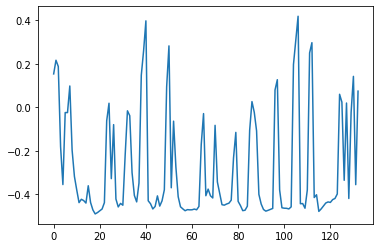

In [15]:
plt.plot(res['x'].squeeze(0)[:, 10].detach().numpy())

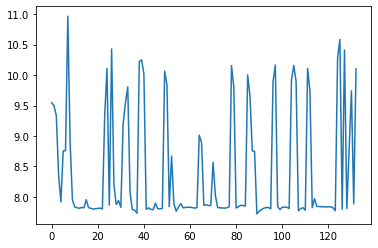

In [16]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=1).detach().numpy())

In [17]:
def extract_mean(wavpath):
    with torch.no_grad():
        wav = torchaudio.load(wavpath)[0]
        res = ssl_model(wav, mask=False, features_only=True)
        return res['x'].squeeze(0).mean(dim=0)


In [18]:
extract_mean(wavpath).size()

torch.Size([768])

In [19]:
out_dir = Path('../out/utt_data')
import os
os.makedirs(out_dir, exist_ok=True)


In [20]:
val_vecs = []
val_moss = []

for key, mos in tqdm(sorted(val_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().numpy()
    np.save(outpath, vec)
    
    val_vecs.append(vec)
    val_moss.append(mos)

  0%|          | 0/1066 [00:00<?, ?it/s]

In [21]:
train_vecs = []
train_moss = []

for key, mos in tqdm(sorted(train_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().numpy()
    np.save(outpath, vec)
    
    train_vecs.append(vec)
    train_moss.append(mos)

  0%|          | 0/4974 [00:00<?, ?it/s]

In [23]:
train_X = np.array(train_vecs)
train_y = np.array(train_moss)
val_X = np.array(val_vecs)
val_y = np.array(val_moss)
train_X.shape

(4974, 768)

In [24]:
os.makedirs('../out/utt_data_npy')
np.save('../out/utt_data_npy/train_X.npy', train_X)
np.save('../out/utt_data_npy/train_y.npy', train_y)
np.save('../out/utt_data_npy/val_X.npy', val_X)
np.save('../out/utt_data_npy/val_y.npy', val_y)